## Q2 Time Series and GD with Python and NumPy

In [30]:
#import the required libraries.
import requests
import json
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import quandl

### Extract the time series from free Quandl API.

In [31]:
#set up Quandl api key 
#extract the dataset of Amazon 
quandl.ApiConfig.api_key = "TPxQbvwJuKJsULN5s-sD"
amazon_data = "WIKI/AMZN"

#take Amazon's historical stock prices and create a dataframe
#this dataset spans from the start date of the stock's availability to 2018-03-27 as this is when Wiki was discontinued 
amazon_stock_data = quandl.get(amazon_data, end_date="2018-03-27")
amazon_price = amazon_stock_data[["Adj. Close"]].copy()
amazon_price.rename(columns={"Adj. Close": "Amazon Price"}, inplace=True)

In [32]:
amazon_price

,Amazon Price
Date,
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635833
1997-05-21,1.427500
1997-05-22,1.395833
...,...
2018-03-21,1581.860000
2018-03-22,1544.100000
2018-03-23,1495.560000


### Extract the time series from free CryptoCompare API.

In [33]:

#extract Bitcoin historical data up to 2018-03-27, we are limited to 2000 rows due to API restrictions.
max_rows = "2000"
final_date_unix = str(datetime.strptime("2018-03-27", "%Y-%m-%d").timestamp())

#create API URL for Bitcoin dataset with the API key, limit and currency (USD)
api_url = f"https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit={max_rows}&api_key=f4c5763630f35a06ac83c3d4b1a307e64f096e2ef5dd641ff793c38bb1e8fa41&toTs={final_date_unix}"

#retrieve and process Bitcoin price data from CryptoCompare API. Format data in JSON structure into the dataframe
response_data = requests.get(api_url).json()
bitcoin_prices = pd.json_normalize(response_data, "Data")

#convert unix timestamp to readable data format and set it as a dataframe index
bitcoin_prices["time"] = pd.to_datetime(bitcoin_prices["time"], unit="s")

#rename columns for clarity
bitcoin_prices = bitcoin_prices[["time", "high"]].rename(columns={"time": "Date", "high": "BTC Price"}).set_index("Date")



In [34]:
bitcoin_prices

,BTC Price
Date,
2012-10-03,12.99
2012-10-04,13.09
2012-10-05,12.97
2012-10-06,12.86
2012-10-07,12.62
...,...
2018-03-22,9107.00
2018-03-23,8935.88
2018-03-24,9036.23


### Merge the two datasets with matching dates.

In [35]:
#combine stock and cryptocurrency data into a single dataFrame
combined_data = amazon_price.join(bitcoin_prices, how="inner")

#select the most recent 250 rows from the combined dataset, this sample size helps maintain a good balance between bias and variance.
#Recent data are more relevant for analysis, especially in fast-changing markets.

test_data = combined_data.tail(250)

In [36]:
test_data

,Amazon Price,BTC Price
Date,,
2017-03-27,846.82,1048.85
2017-03-28,856.00,1068.41
2017-03-29,874.32,1058.66
2017-03-30,876.34,1052.66
2017-03-31,886.54,1088.20
...,...,...
2018-03-20,1586.51,9056.23
2018-03-21,1581.86,9184.51
2018-03-22,1544.10,9107.00


In [37]:
#the prices for Amazon and BTC are stored as variable x_t and y_t respectively.
x_t = test_data["Amazon Price"].round(2).tolist()
y_t = test_data["BTC Price"].tolist()  


### Statistical analysis with OLS

In [38]:
#extracting amazon and bitcoin prices from dataset

amazon_prices = test_data['Amazon Price'].values  
bitcoin_prices = test_data['BTC Price'].values  

#calculate mean of amazon and bitcoin prices
mean_amazon = np.mean(amazon_prices)  
mean_bitcoin = np.mean(bitcoin_prices) 

#calculate the variance of amazon prices and covariance between amazon and bitcoin prices

variance_amazon = np.sum((amazon_prices - mean_amazon) ** 2) / (len(amazon_prices) - 1)
covariance_amazon_bitcoin = np.sum((amazon_prices - mean_amazon) * (bitcoin_prices - mean_bitcoin)) / (len(amazon_prices) - 1)

#calculate the OLS coefficients beta and alpha
beta = covariance_amazon_bitcoin / variance_amazon  # Beta coefficient (slope)
alpha = mean_bitcoin - beta * mean_amazon  # Alpha coefficient (intercept)

print(f'Calculated beta (slope): {beta:.2f}')
print(f'Calculated alpha (intercept): {alpha:.2f}')


Calculated beta (slope): 16.25
Calculated alpha (intercept): -11563.56


### Gradient Descent

In [39]:
#initialise intercept and slope

def gradient_descent(x, y, learning_rate=0.01, max_iterations=1000, convergence_threshold=1e-6):
    alpha, beta = 0.0, 0.0  
    n = len(y)  
    alpha_history = []
    beta_history = []
    history = [] 
    
#calculate current predicted values of y
#calculate the difference between actual and predicted values
#calculate the mean squared error (mse)
    

    for iteration in range(max_iterations):
        predictions = alpha + beta * x  
        errors = y - predictions  
        cost = np.sum(errors**2) / (2 * n)  
        history.append(cost)
       
 #calculate gradients for alpha and beta

        alpha_gradient = -2 * np.sum(errors) / n  
        beta_gradient = -2 * np.sum(errors * x) / n  
        
#update parameters

        alpha -= learning_rate * alpha_gradient  
        beta -= learning_rate * beta_gradient  

        alpha_history.append(alpha)
        beta_history.append(beta)
        
#check convergence        

        if iteration > 0 and abs(history[-2] - cost) < convergence_threshold:
            print(f'Convergence after {iteration} iterations.')
            break

    return alpha_history, beta_history, history

#call the gradient descent function and capture the returned histories
alpha_history, beta_history, loss_history = gradient_descent(norm_x_t, norm_y_t)

#print the final alpha and beta values

print(f'Final alpha (intercept): {alpha_history[-1]:.2f}')
print(f'Final beta (slope): {beta_history[-1]:.2f}')


Convergence after 228 iterations.
Final alpha (intercept): 0.00
Final beta (slope): 0.68


### Plot the loss history, alpha values and beta values

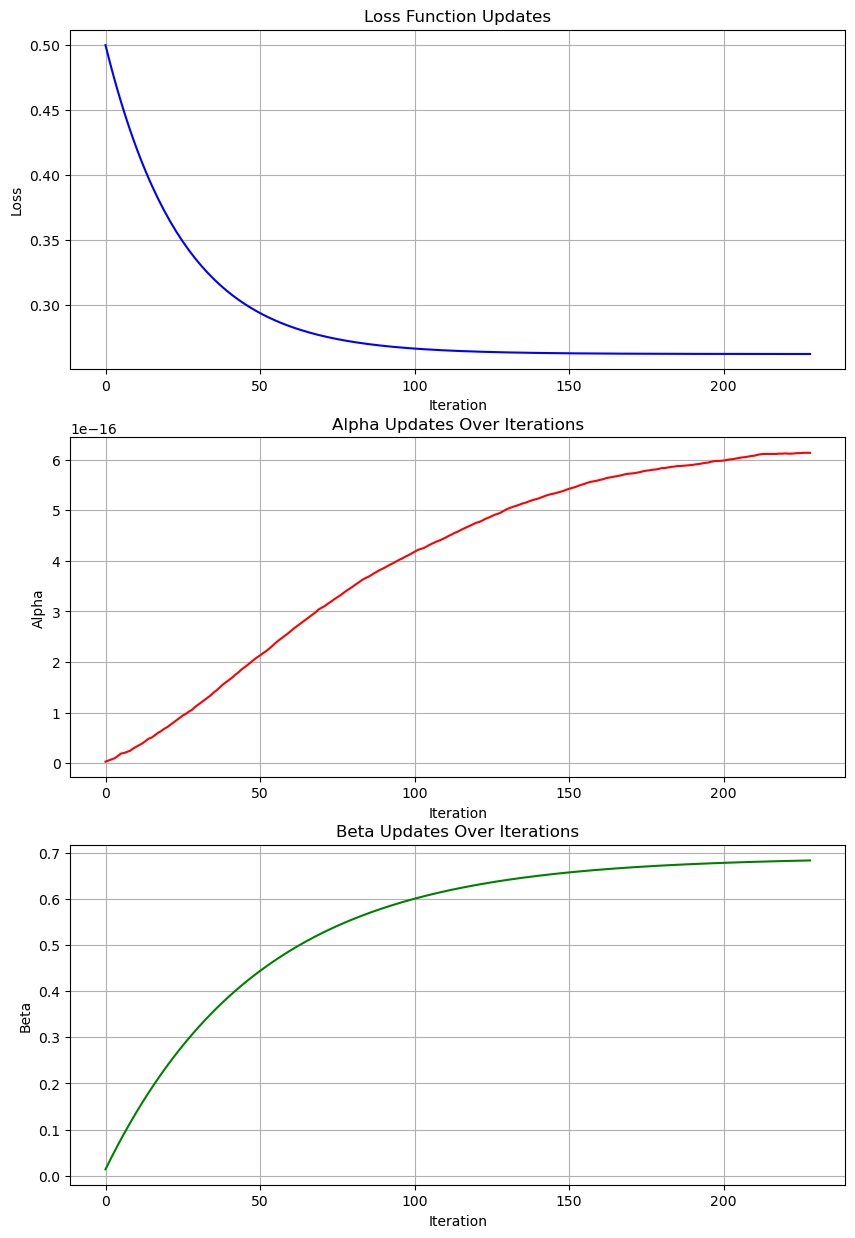

In [40]:

def plot_gradient_descent(alpha_history, beta_history, loss_history):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

#plot the loss history

    axs[0].plot(loss_history, color='blue')
    axs[0].set_title('Loss Function Updates')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)

#plot the alpha values

    axs[1].plot(alpha_history, color='red')
    axs[1].set_title('Alpha Updates Over Iterations')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Alpha')
    axs[1].grid(True)

#plot the beta values

    axs[2].plot(beta_history, color='green')
    axs[2].set_title('Beta Updates Over Iterations')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Beta')
    axs[2].grid(True)

    
plot_gradient_descent(alpha_history, beta_history, loss_history)




##### Overview 

The optimisation via gradient descent targets the minimization of the loss function derived from the regression equation 𝑦 𝑡 = 𝛼 + 𝛽 𝑥 𝑡 + 𝑒 𝑡 y t ​ =α+βx t ​ +e t ​. The analysis over 500 iterations presents a clear narrative of convergence, as seen by the trends in the provided graphs. 

##### Loss Function Updates 

The "Loss Function Updates" graph shows a decreasing trend, indicating the algorithm's effectiveness in minimizing the loss function. Initially, the loss decreases rapidly, demonstrating a significant adjustment to the parameters in aligning with the regression model. As iterations continue, the marginal gains in loss reduction diminish, suggesting that we are nearing the optimal parameters as dictated by our regression equation. 

##### Alpha Updates Over Iterations 

The increasing trend of alpha values in the "Alpha Updates Over Iterations" graph reflects the convergence of the intercept term in our equation. Given that alpha represents the expected Bitcoin price when Amazon's stock price is at baseline, the plateauing of its value indicates a stable prediction baseline being reached. 

##### Beta Updates Over Iterations 

Beta's consistent rise and subsequent levelling, as seen in the "Beta Updates Over Iterations" graph, reflects the model's calibration of the Amazon stock price's predictive influence on Bitcoin prices. The convergence of beta confirms that for each unit increase in Amazon's price, the corresponding change in Bitcoin's price becomes predictable and stable within the historical context of the data used. 


### Interpretation of Results 

In the context of the regression equation 𝑦 𝑡 = 𝛼 + 𝛽 𝑥 𝑡 + 𝑒 𝑡 y t ​ =α+βx t ​ +e t ​ , where 𝑦 𝑡 y t ​ represents the Bitcoin price and 𝑥 𝑡 x t ​ represents the Amazon stock price, the final alpha and beta values from the gradient descent provide us with an estimated linear relationship between the two. 

Alpha (Intercept): The intercept alpha gives us the model's prediction for the Bitcoin price when the Amazon stock price is at zero. It is a baseline from which the Bitcoin price's responsiveness to changes in Amazon's stock price is measured. 

Beta (Slope): The slope beta indicates the expected change in Bitcoin's price for a one-unit increase in Amazon's stock price. A positive beta, as suggested by your analysis, indicates a direct relationship—when Amazon's price increases, so does Bitcoin's, according to the model. 

This interpretation is important for developing an understanding how the stock performance, as reflected by a major company like Amazon, may be linked to cryptocurrency market movements.

#### Convergence Challenges Addressing the challenge of convergence in the gradient descent involves acknowledging the issues and providing solutions: 

###### Outliers: 
Financial data is often has the presence of outliers and can disrupt convergence. By applying transformations and scaling this issue can be mitigated

##### Learning Rate: 
An unsuitably high learning rate might overshoot the minimum, while a low rate might be too slow. Using adaptive learning rates or algorithms like RMSprop or Adam can help adjust the learning rate dynamically for better convergence. 

